# Install dependencies

In [22]:
!pip install torch torchvision --quiet

In [23]:
import shutil
import os
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torchvision.transforms as T
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Load dataset

In [24]:
def get_transform():
    def transform(img, target):
        img = T.ToTensor()(img)  # convert image to tensor
        return img, target       # return target unchanged
    return transform

In [25]:
transform = T.Compose([T.ToTensor()])

train_dataset = torchvision.datasets.VOCDetection(
    root='/kaggle/input/pascal-voc-2007/VOCtrainval_06-Nov-2007',
    year="2007",
    image_set="train",
    download=False,
    transforms=get_transform()
)

test_dataset = torchvision.datasets.VOCDetection(
    root='/kaggle/input/pascal-voc-2007/VOCtest_06-Nov-2007',
    year="2007",
    image_set="test",
    download=False,
    transforms=get_transform()
)

len(train_dataset), len(test_dataset)

(2501, 4952)

# Voc annotation -> Faster R-CNN format

In [26]:
VOC_CLASSES = [
    "__background__",
    "aeroplane", "bicycle", "bird", "boat", "bottle",
    "bus", "car", "cat", "chair", "cow",
    "diningtable", "dog", "horse", "motorbike", "person",
    "pottedplant", "sheep", "sofa", "train", "tvmonitor"
]

def voc_to_target(target):
    objs = target["annotation"]["object"]
    if not isinstance(objs, list):
        objs = [objs]

    boxes, labels = [], []

    for obj in objs:
        name = obj["name"]
        label = VOC_CLASSES.index(name)

        b = obj["bndbox"]
        xmin = float(b["xmin"])
        ymin = float(b["ymin"])
        xmax = float(b["xmax"])
        ymax = float(b["ymax"])

        boxes.append([xmin, ymin, xmax, ymax])
        labels.append(label)

    return {
        "boxes": torch.tensor(boxes, dtype=torch.float32),
        "labels": torch.tensor(labels, dtype=torch.int64),
    }

# DataLoader

In [27]:
def collate_fn(batch):
    imgs, tgts = zip(*batch)
    new_targets = [voc_to_target(t) for t in tgts]
    return list(imgs), new_targets

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
test_loader  = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)

# Load Pretrained Faster R-CNN

In [28]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

num_classes = len(VOC_CLASSES)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

# Training Loop

In [29]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.004, momentum=0.9)

EPOCHS = 10

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for images, targets in tqdm(train_loader):
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
        total_loss += losses.item()

    print(f"Epoch {epoch+1}/{EPOCHS}, Loss = {total_loss:.4f}")

100%|██████████| 626/626 [13:50<00:00,  1.33s/it]


Epoch 1/10, Loss = 315.8322


100%|██████████| 626/626 [13:43<00:00,  1.32s/it]


Epoch 2/10, Loss = 202.8168


100%|██████████| 626/626 [13:42<00:00,  1.31s/it]


Epoch 3/10, Loss = 167.0131


100%|██████████| 626/626 [13:40<00:00,  1.31s/it]


Epoch 4/10, Loss = 142.7403


100%|██████████| 626/626 [13:47<00:00,  1.32s/it]


Epoch 5/10, Loss = 124.3160


100%|██████████| 626/626 [13:45<00:00,  1.32s/it]


Epoch 6/10, Loss = 110.5415


100%|██████████| 626/626 [13:48<00:00,  1.32s/it]


Epoch 7/10, Loss = 101.9785


100%|██████████| 626/626 [13:44<00:00,  1.32s/it]


Epoch 8/10, Loss = 92.9355


100%|██████████| 626/626 [13:41<00:00,  1.31s/it]


Epoch 9/10, Loss = 86.7166


100%|██████████| 626/626 [13:46<00:00,  1.32s/it]

Epoch 10/10, Loss = 79.6341


# Save model

In [1]:
torch.save(model.state_dict(), "fasterrcnn_voc.pth")
print("Model saved.")

NameError: name 'torch' is not defined

# Inference

In [51]:
TEST_INDEX = 75

img, target = test_dataset[TEST_INDEX]
orig = np.array(img.permute(1,2,0))

model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]

# Visualize detections

In [52]:
def show_prediction(image_tensor, prediction, threshold=0.5):
    img = cv2.cvtColor(image_tensor.clip(0,1), cv2.COLOR_RGB2BGR)

    for box, score, label in zip(prediction['boxes'], prediction['scores'], prediction['labels']):
        if score < threshold:
            continue
        x1, y1, x2, y2 = box.int().tolist()
        cls_name = VOC_CLASSES[label]
        cv2.rectangle(img, (x1,y1), (x2,y2), (0,255,0), 2)
        cv2.putText(img, f"{cls_name} {score:.2f}", (x1,y1-5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,0,0), 2)

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10,8))
    plt.imshow(img)
    plt.axis("off")
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


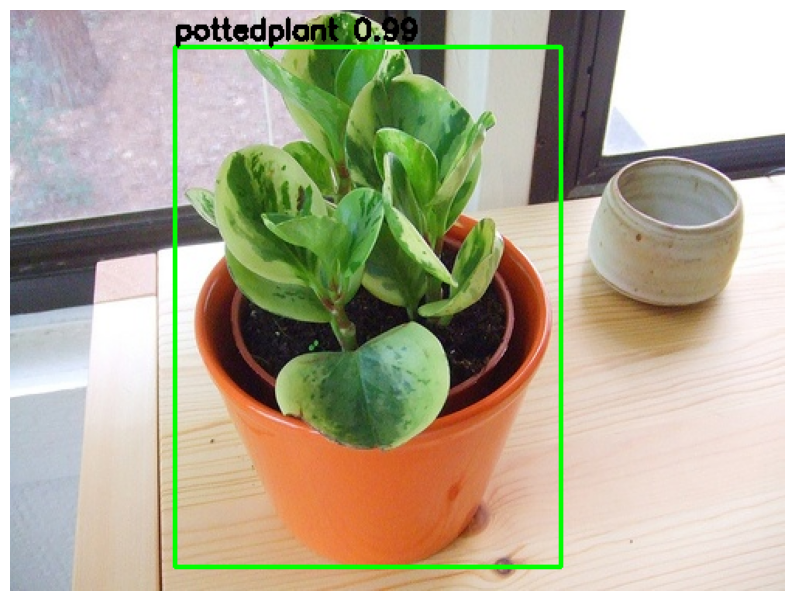

In [53]:
show_prediction(orig, prediction)